# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Chaves, Noelia
- Frau, Johanna

### Mentora:

- Dal Lago, Virginia

### Práctico: Introducción al aprendizaje automático

## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.




## Objetivos generales

  

## Objetivos específicos
* Emplear y calcular la performance de un modelo de aprendizaje supervisado de tipo             support vector machine, separando para ello en dos clases: envíos rápidos (demoran            menos de 3 días) y lentos (demoran 3 o más días). ¿Existen outliers? ¿Son los datos                linealmente separables? Si no lo son, ¿qué kernel creen se podría emplear para             realizar la proyección? 
* En la problemática propuesta, podemos dividir la experiencia del usuario en tres            situaciones diferentes: el envío llegó antes de lo prometido, el día prometido o             después del día prometido. Definir una o más métricas que nos permitan determinar             la performance de los modelos desarrollados considerando las tres posibles          experiencias de usuario de interés.  
* Determinar, desarrollar y calcular la performance (según las métricas definidas en el            punto anterior) de un modelo de aprendizaje supervisado de tipo ensemble de            modelos (considerando todas las clases posibles). ¿Cuál es la diferencia con los            modelos más sencillos del práctico anterior? ¿Cómo es la performance en este            caso? ¿Cómo creen que puede incrementarse aún más la performance utilizando           este tipo de modelos?
* Elegir las dos features que considere más relevante y desarrollar un modelo de             clustering (sin utilizar la información del target, i.e., ​shipment_days ​ ).  
* Realizar una visualización de los diferentes clusters.  ¿Cómo son los tamaños relativos?  ¿Parecen adecuados para el problema de interés?  ¿Representan a todas las clases?  ¿Qué medida podemos utilizar para inspeccionar el contenido de los clusters?           Aplicarla al problema y comentar el resultado obtenido.  ¿Qué modificaciones deberíamos llevar a cabo para que los clusters sean más            representativos del problema de interés? 
* Repetir el análisis anterior empleando en el modelo de clustering un número            mayor de clusters (que difiera del anterior en al menos 3). ¿Qué diferencias             observa en ambos casos? 
* Utilizando todos los features y el número de clusters que considere mejor para el              problema de interés, desarrollar un modelo de clustering. ​Calcular accuracy y la            performance según las métricas definidas en el segundo punto. ¿Cómo es la            performance comparada a la del modelo de aprendizaje supervisado? Comente          sobre cuál modelo es mejor y por qué. 
* Emplear un embedding sobre las features seleccionadas (por ejemplo, PCA) y           emplear el mismo modelo de clustering desarrollado en el punto anterior. ¿Cómo se             modifican las métricas? ¿Y el tiempo de entrenamiento? Comente sobre las ventajas            y/o desventajas de aplicar el embedding. 


## Desarrollo del trabajo

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
import sklearn

from datetime import timedelta
from IPython.display import HTML
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import preprocessing
from sklearn import tree
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures

### Lectura y análisis inicial de los datos

In [3]:
url = "https://raw.githubusercontent.com/cnoeliachaves/csv/master/dataset_sample_corrected.csv"

dataset = pandas.read_csv(url, dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
dataset.shape

(500000, 12)

In [21]:
dataset.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        500000 non-null object
sender_zipcode      500000 non-null int64
receiver_state      500000 non-null object
receiver_zipcode    500000 non-null int64
shipment_type       500000 non-null object
quantity            500000 non-null int64
service             500000 non-null int64
status              500000 non-null object
date_created        500000 non-null datetime64[ns]
date_sent           499971 non-null datetime64[ns]
date_visit          499398 non-null datetime64[ns]
shipment_days       499398 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 45.8+ MB


In [4]:
np.random.seed(1234) #con propositos de reproducibilidad
dataset.sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
459222,SP,4691,PA,68330,standard,1,1,done,2019-02-02,2019-02-05 07:12:00,2019-03-11 16:04:00,21.0
28619,SP,3017,RS,98130,standard,1,1,done,2019-02-11,2019-02-18 16:17:00,2019-03-14 06:32:00,15.0
453020,SP,14405,MG,37130,standard,1,2,done,2019-03-05,2019-03-09 04:44:28,2019-03-13 16:07:00,2.0
16289,SP,4904,SP,15500,express,1,3,done,2019-03-12,2019-03-14 15:09:00,2019-03-20 18:05:00,4.0
337995,SP,4266,MA,65061,standard,1,4,done,2019-03-13,2019-03-15 01:18:29,2019-03-25 11:17:00,6.0
232178,SP,13290,SP,6050,super,1,6,done,2019-02-28,2019-03-01 02:25:00,2019-03-07 11:20:37,1.0
220911,SP,6311,SP,11520,express,1,0,done,2019-03-04,2019-03-06 15:36:00,2019-03-08 18:59:00,1.0
33028,SP,7803,SP,13503,express,1,0,done,2019-03-08,2019-03-08 17:05:00,2019-03-12 16:01:00,2.0
35358,SP,1536,PE,56828,standard,1,1,done,2019-03-03,2019-03-05 11:22:46,2019-03-19 13:18:00,8.0
47950,SP,12322,ES,29680,standard,2,1,done,2019-03-05,2019-03-06 10:34:00,2019-03-18 15:06:00,7.0


### Limpieza de datos

En esta sección retomaremos algunos puntos del práctico anterior con el objetivo de limpiar nuestro dataset.

#### Shipment day anómalos 

En primer lugar, eliminaremos los valores de shipment days negativos.

In [5]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    return dataset[mask] 

In [6]:
dataset_clean = clean_shipment_days(dataset)

####Fechas anómalas

En el análisis realizado en el práctico anterior de las 3 variables con información de fechas y horas encontramos que la variable date_created cuenta con valores que caen fuera del intervalo temporal considerado y que todos ellos se encuentran ubicados en el mes de Junio de 2019. Luego de haber realizado una inspección de esta información anómala llegamos a la conclusión que los mismos podrían deberse a un error en el proceso de carga y que en realidad son datos de Enero de 2019. 

Siguiendo esta idea decidimos en este momento subsanar este posible error de carga haciendo que la información de la variable date_created correspondiente al mes de Junio de 2019 sea ahora del mes de Enero de 2019.

In [7]:
date_created_junio = dataset_clean[dataset_clean['date_created'].map(lambda x: x.month) == 6]
date_created_junio

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
14265,SP,2350,RJ,20261,express,1,7,done,2019-06-27,2019-02-06 05:57:00,2019-03-01 11:31:00,17.0
18211,SP,7756,SP,13214,express,1,7,done,2019-06-27,2019-02-06 05:00:00,2019-03-01 09:08:00,17.0
27700,SP,5034,GO,74565,standard,1,7,done,2019-06-26,2019-02-06 10:56:00,2019-03-01 11:54:00,17.0
28540,SP,9060,MA,65050,standard,1,4,done,2019-06-20,2019-02-06 10:00:00,2019-03-01 12:02:00,17.0
33158,SP,16204,MG,31910,standard,2,7,done,2019-06-27,2019-02-06 04:03:00,2019-03-01 16:43:00,17.0
38127,SP,2460,SP,13335,express,1,7,done,2019-06-26,2019-03-06 01:18:00,2019-03-07 14:03:00,0.0
42758,SP,1042,SP,11070,express,1,4,done,2019-06-25,2019-02-06 05:01:00,2019-03-01 16:09:00,17.0
43607,SP,6422,RS,91750,standard,1,7,done,2019-06-19,2019-02-06 04:41:00,2019-03-01 14:30:00,17.0
45731,SP,14405,ES,29164,standard,1,7,done,2019-06-22,2019-03-06 03:02:00,2019-03-07 04:27:00,0.0
58502,SP,12950,ES,29800,standard,1,7,done,2019-06-25,2019-02-06 04:42:00,2019-03-01 07:29:00,17.0


In [8]:
date_created_junio = dataset_clean['date_created'].map(lambda x: 
                                                       x+timedelta(days=-151) 
                                                       if x.month==6 else x)

In [9]:
dataset_clean.loc[:,'date_created'] = date_created_junio

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
dataset_clean['date_created'].dt.month.unique()

array([ 3,  2,  1,  4, 12, 10, 11], dtype=int64)

In [11]:
dataset_clean.describe(include='datetime64')

,date_created,date_sent,date_visit
count,499350,499350,499350
unique,124,81276,55668
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20424,113,621
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-04-29 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


En el describe de arriba, podemos ver que la última fecha de creación es posterior a la última fecha de data_sent como date_visit, pero consideramos que dichos datos son correctos, ya que no contamos con el completo dataset.

#### Valores nulos

Veamos cuantos valores nulos tenemos

In [12]:
null_values_count = dataset_clean.isnull().sum()
null_values_count[null_values_count > 0]

Series([], dtype: int64)

Podemos ver que no tenemos valores nulos en el dataset.

#### Limpieza de las fechas anomálas

Ahora limpiaremos el dataset sacando todas aquellas fechas que no se siguen en la línea temporal. 

In [13]:
date_created_before_date_sent = dataset_clean.date_created < dataset_clean.date_sent #Filtramos date_created menores que date_sent

date_sent_before_date_visit = dataset_clean.date_sent < dataset_clean.date_visit #Filtramos date_sent menores que date_visit

date_created_before_date_visit = dataset_clean.date_created < dataset_clean.date_visit #Filtramos date_created menores que date_visit


In [14]:
dataset_clean = dataset_clean[date_created_before_date_sent].dropna() # solo fechas de creacion antes de la fecha de envio
dataset_clean = dataset_clean[date_created_before_date_visit].dropna()# solo fechas de creacion antes de la fecha de visita
dataset_clean = dataset_clean[date_sent_before_date_visit].dropna()# solo fechas de envios antes de la fecha de visita
dataset_clean.sample(5)

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
61209,SP,9520,BA,46940,standard,1,1,done,2019-03-15,2019-03-19 13:17:00,2019-03-27 15:24:00,6.0
72136,SP,9510,MG,35500,standard,1,1,done,2019-02-24,2019-02-25 18:59:00,2019-03-15 08:59:00,11.0
192050,SP,9635,PR,87033,standard,1,1,done,2019-03-18,2019-03-19 08:12:00,2019-03-28 15:29:00,7.0
287022,SP,8586,DF,70384,standard,1,4,done,2019-03-08,2019-03-12 07:26:55,2019-03-14 06:12:00,2.0
467512,SP,2180,GO,74255,express,1,3,done,2019-03-21,2019-03-24 04:57:00,2019-03-29 22:00:00,4.0


### La importancia de predecir el valor de la variable shipment_days

Uno de los objetivos principales del análisis propuesto en esta mentoría es predecir (dar un número aproximado de días hábiles) el tiempo entre que se despacha del correo hasta que el mismo llega a la casa del comprador. 

Es decir, queremos predecir el feature shipment_days.

Por lo tanto este sería el target de un algoritmo de aprendizaje automático. Si bien este feature originalmente es información de tipo numérica en el práctico anterior utilizamos enconding para convertirla en una variable categórica. Así, esto nos da la posibilidad de trabajar con diferentes modelos de aprendizaje automático utilizando el mismo feature como target pero en sus diferentes versiones.

Frente a este problema consideramos que el estado de Brasil que recibe el envío (receiver_state) es un feature importante a tener en cuenta (mientras más lejos esté de San Pablo probablemente demore más) y probablemente también el código postal de dicho estado (receiver_zipcode). Por otro lado, el tipo de correo (service) también puede ser una variable importante a tener en cuenta porque la calidad de servicio impactará directamente en los días que tarda en llegar el pedido.



In [16]:
dataset_clean.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
17790,SP,13880,SP,9060,express,1,0,done,2019-02-28,2019-02-28 13:32:00,2019-03-01 14:25:00,1.0
63099,SP,3508,MS,79140,express,1,0,done,2019-02-27,2019-03-01 15:23:00,2019-03-08 14:58:00,2.0
461551,SP,2120,SP,4836,express,1,0,done,2019-02-19,2019-02-20 11:57:00,2019-03-08 09:32:00,9.0
481950,SP,14161,BA,45830,standard,1,2,done,2019-02-26,2019-02-27 22:54:01,2019-03-25 18:48:00,15.0
126304,SP,1026,MG,37564,standard,1,1,done,2019-02-19,2019-02-25 17:52:00,2019-03-07 13:14:00,5.0


In [17]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496954 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        496954 non-null object
sender_zipcode      496954 non-null int64
receiver_state      496954 non-null object
receiver_zipcode    496954 non-null int64
shipment_type       496954 non-null object
quantity            496954 non-null int64
service             496954 non-null int64
status              496954 non-null object
date_created        496954 non-null datetime64[ns]
date_sent           496954 non-null datetime64[ns]
date_visit          496954 non-null datetime64[ns]
shipment_days       496954 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 49.3+ MB


Luego de haber limpiado nuestro dataset observamos que contamos con 496954 filas con información, es decir la limpieza solo afectó aproximadamente al 1% de los datos originales.



### Separación en el conjunto de entrenamiento y evaluación 

In [46]:
#xOne=dataset_clean[dataset_clean['shipment_days']>3]['shipment_days']
#xTwo=dataset_clean[dataset_clean['shipment_days']<=3]['shipment_days']
shipment_days = dataset_clean['shipment_days'].astype(int)
shipment_days_byclass = [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if 0==row:
        shipment_days_byclass[line] = 0
    elif 1==row:
        shipment_days_byclass[line] = 1     
    elif 2==row:
        shipment_days_byclass[line] = 2
    elif 3==row:
        shipment_days_byclass[line] = 3
    elif 4==row:
        shipment_days_byclass[line] = 4
    elif 5==row:
        shipment_days_byclass[line] = 5        
    else:
        shipment_days_byclass[line] = 6

In [49]:
dataset_clean['shipment_days_byclass'] = shipment_days_byclass
dataset_clean.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,shipment_days_byclass
0,SP,1039,SP,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,5
1,SP,3004,PB,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,5
2,SP,3262,RJ,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,4
3,SP,12237,SP,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,2
4,SP,9350,AP,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,6


In [50]:
X = dataset_clean[['service','receiver_zipcode']]
X

,service,receiver_zipcode
0,1,14500
1,1,58670
2,2,22723
3,2,18682
4,1,68908
5,9,91060
6,0,7776
7,1,35910
8,2,21755
9,0,38703


In [36]:
#y = dataset_clean['shipment_days']

In [52]:
Y = (dataset_clean[['shipment_days_byclass']] <= 3).astype(np.int8)
Y

,shipment_days_byclass
0,0
1,0
2,0
3,1
4,0
5,1
6,1
7,0
8,0
9,1


,shipment_days
0,0
1,0
2,0
3,1
4,0
5,1
6,1
7,0
8,0
9,1


In [53]:
#X = np.array(list(zip(xOne,xTwo)))
#Y = (X[:,1] <= 3).astype(np.int8)
col = Y['shipment_days_byclass'].map({1:'r', 0:'b'})
col

0         b
1         b
2         b
3         r
4         b
5         r
6         r
7         b
8         b
9         r
10        r
11        r
12        r
13        r
14        r
15        b
16        b
17        r
18        r
19        b
20        r
21        r
22        r
23        b
24        r
25        r
26        r
27        b
28        r
29        r
         ..
499969    b
499970    r
499971    b
499972    b
499973    r
499974    r
499975    r
499976    r
499977    r
499978    b
499979    b
499980    r
499981    b
499982    b
499983    r
499984    r
499985    b
499986    b
499987    b
499988    r
499989    b
499990    b
499991    r
499992    r
499993    r
499994    r
499995    r
499996    r
499998    b
499999    b
Name: shipment_days_byclass, Length: 496954, dtype: object

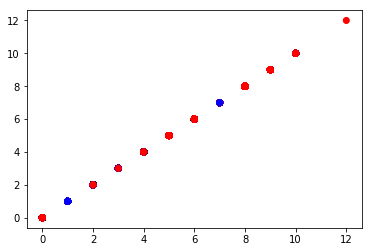

In [54]:
plt.scatter(X[['service']], X[['service']], c=col);
#plt.scatter(X, X, s=50 , c=col, cmap=plt.cm.Spectral);

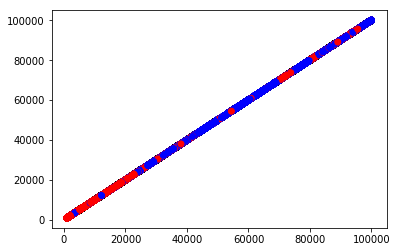

In [55]:
plt.scatter(X[['receiver_zipcode']], X[['receiver_zipcode']], c=col);

In [56]:
#clf = sklearn.svm.LinearSVC()
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1, random_state=0)
clf.fit(X, Y)

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

#Habria que ver el tema de los outliers a que se refiere
Los datos no son linealmente separables.
#Investigar que kernels creen que se podrian utilizar para realizar la proyeccion

In [ ]:
#from sklearn.svm import OneClassSVM
#clf = OneClassSVM(gamma='auto').fit(X)
#clf.predict(X)

y = -5699.6927 * x + -92116.7315


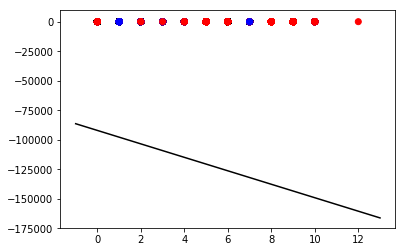

In [57]:
w = clf.coef_[0]
a = -w[0] / w[1]
b = - clf.intercept_[0] / w[1]
xx = np.linspace(numpy.amin(X[['service']].to_numpy()) - 1, numpy.amax(X[['service']].to_numpy()) + 1)
yy = a * xx + b

plt.plot(xx, yy, 'k-', label="non weighted div")
#plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap=plt.cm.Spectral);
plt.scatter(X[['service']], X[['service']], c=col);
print (("y = %.4f * x + %.4f") % (a, b))

In [40]:
import numpy
numpy.amin(X[['service']].to_numpy())

0

y = -5699.6927 * x + -92116.7315


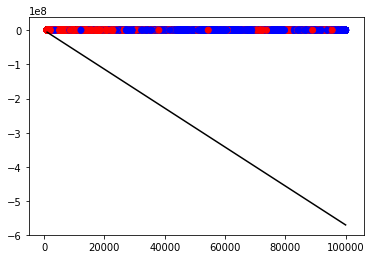

In [58]:
w = clf.coef_[0]
a = -w[0] / w[1]
b = - clf.intercept_[0] / w[1]
xx = np.linspace(numpy.amin(X[['receiver_zipcode']].to_numpy()) - 1, numpy.amax(X[['receiver_zipcode']].to_numpy()) + 1)
yy = a * xx + b

plt.plot(xx, yy, 'k-', label="non weighted div")
#plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap=plt.cm.Spectral);
plt.scatter(X[['receiver_zipcode']], X[['receiver_zipcode']], c=col);
print (("y = %.4f * x + %.4f") % (a, b))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean)#OrRd_r)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Greys)

In [ ]:
utils.plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T)
predictions = clf.predict(X)
print ('Accuracy: %d ' % ((np.sum(Y == predictions))/float(Y.size)*100))